In [2]:
import os
import json
from glob import glob
import pandas as pd
import numpy as np

In [55]:
data = pd.read_csv("Duolingo Data/duolingo_train_data_clean.csv")
data

,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,prompt,countries,days,client,session,time
0,block_1,8XTyQUAl0101,Le,DET,Definite=Def|Gender=Masc|Number=Sing|fPOS=DET++,det,2,0,YjS/mQOx,reverse_translate,The boy,CA,0.005,web,lesson,14.0
1,block_1,8XTyQUAl0102,garçon,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,0,YjS/mQOx,reverse_translate,The boy,CA,0.005,web,lesson,14.0
2,block_2,8XTyQUAl0201,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,4,0,YjS/mQOx,reverse_translate,I am a woman.,CA,0.005,web,lesson,14.0
3,block_2,8XTyQUAl0202,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,4,0,YjS/mQOx,reverse_translate,I am a woman.,CA,0.005,web,lesson,14.0
4,block_2,8XTyQUAl0203,une,DET,Definite=Ind|Gender=Fem|Number=Sing|PronType=D...,det,4,0,YjS/mQOx,reverse_translate,I am a woman.,CA,0.005,web,lesson,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243977,block_85319,93hqXjPO0202,journée,NOUN,Gender=Fem|Number=Sing|fPOS=NOUN++,ROOT,0,0,a3jLlbgc,reverse_translate,Have a good day!,US,15.717,ios,practice,7.0
243978,block_85320,93hqXjPO0301,Le,DET,Definite=Def|Gender=Masc|Number=Sing|fPOS=DET++,det,2,0,a3jLlbgc,reverse_translate,The month of March,US,15.717,ios,practice,5.0
243979,block_85320,93hqXjPO0302,mois,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,1,a3jLlbgc,reverse_translate,The month of March,US,15.717,ios,practice,5.0
243980,block_85320,93hqXjPO0303,de,ADP,fPOS=ADP++,case,4,0,a3jLlbgc,reverse_translate,The month of March,US,15.717,ios,practice,5.0


## Feature Engineering

In [56]:
#Churn Time
data['churn_time'] = data.groupby('user_id')['days'].transform(lambda x: x.max() - x.min())
data['churn_time'] = data['churn_time'].apply(np.floor)
#Variance in Response Time
block_times = data.groupby(['user_id', 'block_id'])['time'].mean().reset_index()
variance_df = block_times.groupby('user_id')['time'].var().reset_index()
variance_df = variance_df.rename(columns={'time': 'response_time_variance'})
data = pd.merge(data, variance_df, on='user_id', how='left')
#Word Average Correctness
data['token_correctness'] = data.groupby('token')['correctness'].transform('mean')
#group by block_id and take the average of token_correctness and make it as a new column
data["block_wise_correctness"] = data.groupby(['block_id'])['token_correctness'].transform('mean')
#make a new column which has value 1 if churn_time is 0 to 6, 2 if churn_time is 7 to 13, 3 if churn_time is 14 to 20 and 4 if churn_time is greater than 20
data['churn_time_category'] = pd.cut(data['churn_time'], bins=[0, 6, 13, 20, 1000], labels=[1, 2, 3, 4])
data

,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,...,countries,days,client,session,time,churn_time,response_time_variance,token_correctness,block_wise_correctness,churn_time_category
0,block_1,8XTyQUAl0101,Le,DET,Definite=Def|Gender=Masc|Number=Sing|fPOS=DET++,det,2,0,YjS/mQOx,reverse_translate,...,CA,0.005,web,lesson,14.0,20.0,100.722709,0.096324,0.082890,3
1,block_1,8XTyQUAl0102,garçon,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,0,YjS/mQOx,reverse_translate,...,CA,0.005,web,lesson,14.0,20.0,100.722709,0.069455,0.082890,3
2,block_2,8XTyQUAl0201,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,4,0,YjS/mQOx,reverse_translate,...,CA,0.005,web,lesson,14.0,20.0,100.722709,0.038270,0.109109,3
3,block_2,8XTyQUAl0202,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,4,0,YjS/mQOx,reverse_translate,...,CA,0.005,web,lesson,14.0,20.0,100.722709,0.062308,0.109109,3
4,block_2,8XTyQUAl0203,une,DET,Definite=Ind|Gender=Fem|Number=Sing|PronType=D...,det,4,0,YjS/mQOx,reverse_translate,...,CA,0.005,web,lesson,14.0,20.0,100.722709,0.230538,0.109109,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243977,block_85319,93hqXjPO0202,journée,NOUN,Gender=Fem|Number=Sing|fPOS=NOUN++,ROOT,0,0,a3jLlbgc,reverse_translate,...,US,15.717,ios,practice,7.0,15.0,516.805343,0.208333,0.242950,3
243978,block_85320,93hqXjPO0301,Le,DET,Definite=Def|Gender=Masc|Number=Sing|fPOS=DET++,det,2,0,a3jLlbgc,reverse_translate,...,US,15.717,ios,practice,5.0,15.0,516.805343,0.096324,0.180591,3
243979,block_85320,93hqXjPO0302,mois,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,1,a3jLlbgc,reverse_translate,...,US,15.717,ios,practice,5.0,15.0,516.805343,0.129870,0.180591,3
243980,block_85320,93hqXjPO0303,de,ADP,fPOS=ADP++,case,4,0,a3jLlbgc,reverse_translate,...,US,15.717,ios,practice,5.0,15.0,516.805343,0.422096,0.180591,3


In [57]:
#Session is considered different if there is 1h gap
def assign_session(group):
    # Sort the group by 'days'
    group = group.sort_values("days").copy()
    # Calculate the time difference between consecutive rows
    group['time_diff'] = group['days'].diff().fillna(0)
    # A new session starts if the difference exceeds 0.06 (first row always in session 1)
    group['session_id'] = (group['time_diff'] > 0.0417).cumsum() + 1
    return group
data = data.groupby(['user_id'], group_keys=False).apply(assign_session)
data

/var/folders/rk/chdw58s567j63rrc5xnh83gw0000gn/T/ipykernel_40237/2485980414.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['user_id'], group_keys=False).apply(assign_session)


,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,...,client,session,time,churn_time,response_time_variance,token_correctness,block_wise_correctness,churn_time_category,time_diff,session_id
231950,block_80999,eiUNqChP0101,La,DET,Definite=Def|Gender=Fem|Number=Sing|fPOS=DET++,det,2,0,+4kwmfjD,reverse_translate,...,ios,lesson,3.0,0.0,48.512380,0.163613,0.134468,NaN,0.000,1
231951,block_80999,eiUNqChP0102,femme,NOUN,Gender=Fem|Number=Sing|fPOS=NOUN++,ROOT,0,1,+4kwmfjD,reverse_translate,...,ios,lesson,3.0,0.0,48.512380,0.105323,0.134468,NaN,0.000,1
231952,block_81000,uUUiSODd0101,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,3,0,+4kwmfjD,reverse_translate,...,ios,lesson,5.0,0.0,48.512380,0.038270,0.052890,NaN,0.003,1
231953,block_81000,uUUiSODd0102,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,3,0,+4kwmfjD,reverse_translate,...,ios,lesson,5.0,0.0,48.512380,0.062308,0.052890,NaN,0.000,1
231954,block_81000,uUUiSODd0103,rouge,ADJ,Gender=Fem|Number=Sing|fPOS=ADJ++,ROOT,0,0,+4kwmfjD,reverse_translate,...,ios,lesson,5.0,0.0,48.512380,0.058091,0.052890,NaN,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128403,block_44833,B9YtEYi10201,Leurs,DET,Gender=Masc|Number=Plur|fPOS=DET++,nmod:poss,2,0,zNp6qJb4,reverse_tap,...,android,lesson,2859.0,1.0,58337.108941,0.300341,0.195399,1,0.000,5
128402,block_44832,B9YtEYi10102,chapeau,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,0,zNp6qJb4,reverse_tap,...,android,lesson,10.0,1.0,58337.108941,0.116976,0.241297,1,0.000,5
128401,block_44832,B9YtEYi10101,Votre,DET,Gender=Masc|Number=Sing|fPOS=DET++,nmod:poss,2,0,zNp6qJb4,reverse_tap,...,android,lesson,10.0,1.0,58337.108941,0.365617,0.241297,1,0.000,5
128405,block_44834,B9YtEYi10301,Notre,DET,Gender=Masc|Number=Sing|fPOS=DET++,nmod:poss,2,0,zNp6qJb4,reverse_tap,...,android,lesson,4.0,1.0,58337.108941,0.282116,0.199546,1,0.000,5


In [59]:
data.to_csv("Duolingo_Data_02_18.csv", index=False)

<Axes: ylabel='Density'>

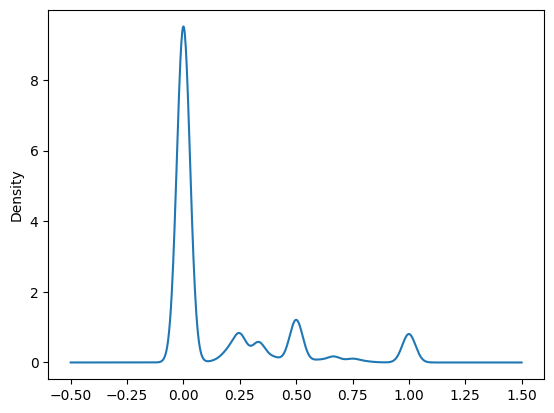

In [58]:
#By grouping data by block_id, calculate the average correctness and plot the density plot of its distribution
data.groupby('block_id')['correctness'].mean().plot(kind='density')

<Axes: ylabel='Frequency'>

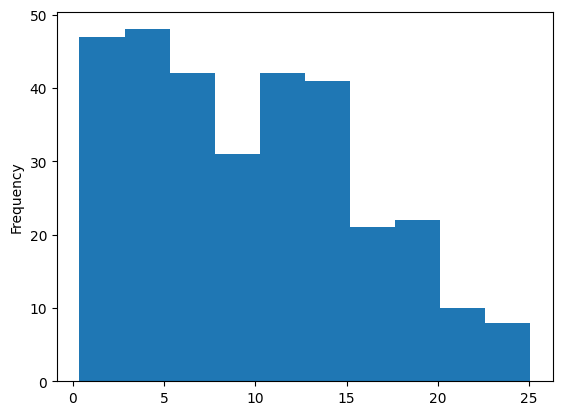

In [38]:
#By grouping by user_id, plot frequency plot of churn time
data.groupby('user_id')['churn_time'].mean().plot(kind='hist')

<Axes: ylabel='Density'>

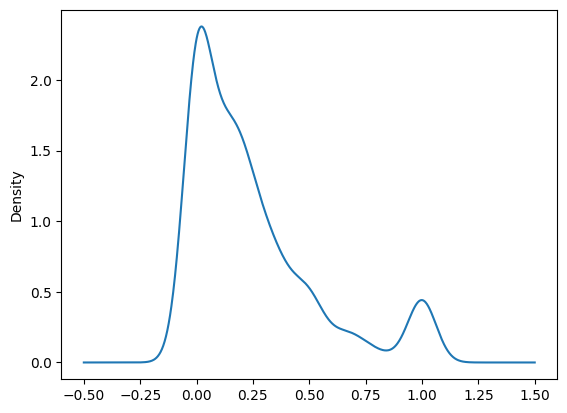

In [90]:
data.groupby('token')['token_correctness'].first().plot(kind='density')

<Axes: xlabel='pos'>

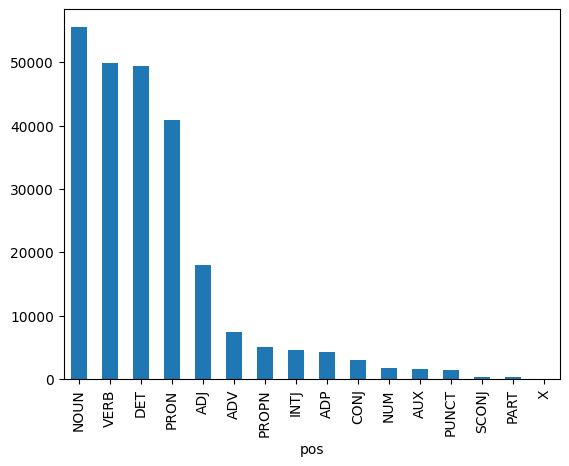

In [47]:
#Plot bar plot of dep_rel
data['pos'].value_counts().plot(kind='bar')

<Axes: ylabel='Density'>

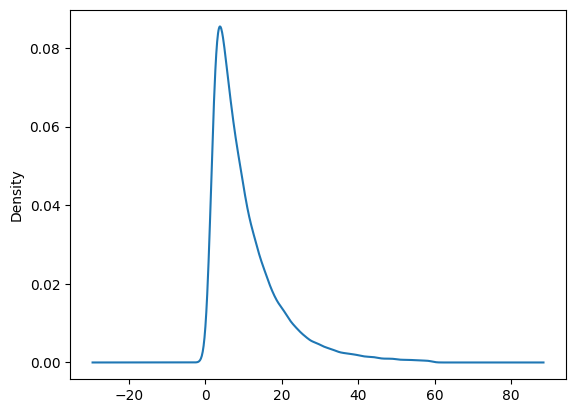

In [54]:
#Subset data on group_time < 600 and group by block_id and calculate mean time and plot density plot

data[data['time'] < 60].groupby('block_id')['time'].mean().plot(kind='density')

In [8]:
data[data["user_id"] == "V9kFlUzc"].head(30)

,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,prompt,countries,days,client,session,time,churn_time,response_time_variance,token_correctness
167205,block_58051,uI1W4VZM0101,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,3,0,V9kFlUzc,reverse_translate,I am red!,CA,1.026,web,lesson,7.0,0.36,79.259211,0.038270
167206,block_58051,uI1W4VZM0102,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,3,0,V9kFlUzc,reverse_translate,I am red!,CA,1.026,web,lesson,7.0,0.36,79.259211,0.062308
167207,block_58051,uI1W4VZM0103,rouge,ADJ,Gender=Fem|Number=Sing|fPOS=ADJ++,ROOT,0,0,V9kFlUzc,reverse_translate,I am red!,CA,1.026,web,lesson,7.0,0.36,79.259211,0.058091
167208,block_58052,uI1W4VZM0201,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,3,0,V9kFlUzc,reverse_translate,I am rich!,CA,1.026,web,lesson,6.0,0.36,79.259211,0.038270
167209,block_58052,uI1W4VZM0202,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,3,0,V9kFlUzc,reverse_translate,I am rich!,CA,1.026,web,lesson,6.0,0.36,79.259211,0.062308
167210,block_58052,uI1W4VZM0203,riche,ADJ,Gender=Fem|Number=Sing|fPOS=ADJ++,ROOT,0,0,V9kFlUzc,reverse_translate,I am rich!,CA,1.026,web,lesson,6.0,0.36,79.259211,0.063620
167211,block_58053,920i24Od0101,Il,PRON,Gender=Masc|Number=Sing|Person=3|PronType=Prs|...,nsubj,3,0,V9kFlUzc,reverse_translate,He is rich.,CA,1.027,web,lesson,7.0,0.36,79.259211,0.067449
167212,block_58053,920i24Od0102,est,VERB,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbF...,cop,3,0,V9kFlUzc,reverse_translate,He is rich.,CA,1.027,web,lesson,7.0,0.36,79.259211,0.084715
167213,block_58053,920i24Od0103,riche,ADJ,Gender=Masc|Number=Sing|fPOS=ADJ++,ROOT,0,1,V9kFlUzc,reverse_translate,He is rich.,CA,1.027,web,lesson,7.0,0.36,79.259211,0.063620
167214,block_58054,920i24Od0201,Je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,2,0,V9kFlUzc,reverse_translate,I eat.,CA,1.027,web,lesson,5.0,0.36,79.259211,0.038270


In [14]:
data[data["user_id"] == "a3jLlbgc"].tail(50)

,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,prompt,countries,days,client,session,time,churn_time,response_time_variance,token_correctness
243932,block_85307,Q4loQs3A0103,sûrement,ADV,fPOS=ADV++,conj,1,0,a3jLlbgc,reverse_translate,Slowly but surely,US,15.709,ios,practice,9.0,15.715,516.805343,0.000000
243933,block_85308,Q4loQs3A0201,Mais,CONJ,fPOS=CONJ++,cc,4,0,a3jLlbgc,reverse_translate,"But, I am here.",US,15.709,ios,practice,5.0,15.715,516.805343,0.272727
243934,block_85308,Q4loQs3A0202,je,PRON,Number=Sing|Person=1|PronType=Prs|fPOS=PRON++,nsubj,4,0,a3jLlbgc,reverse_translate,"But, I am here.",US,15.709,ios,practice,5.0,15.715,516.805343,0.117145
243935,block_85308,Q4loQs3A0203,suis,VERB,Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbF...,cop,4,0,a3jLlbgc,reverse_translate,"But, I am here.",US,15.709,ios,practice,5.0,15.715,516.805343,0.062308
243936,block_85308,Q4loQs3A0204,ici,ADV,fPOS=ADV++,ROOT,0,1,a3jLlbgc,reverse_translate,"But, I am here.",US,15.709,ios,practice,5.0,15.715,516.805343,0.172691
243937,block_85309,6HJZJX1H0101,Un,DET,Definite=Ind|Gender=Masc|Number=Sing|PronType=...,det,2,1,a3jLlbgc,listen,NaN,US,15.710,ios,practice,4.0,15.715,516.805343,0.139300
243938,block_85309,6HJZJX1H0102,bébé,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,0,a3jLlbgc,listen,NaN,US,15.710,ios,practice,4.0,15.715,516.805343,0.043478
243939,block_85310,6HJZJX1H0201,As,NOUN,fPOS=PROPN++,ROOT,0,0,a3jLlbgc,reverse_translate,Do you have two babies?,US,15.710,ios,practice,23.0,15.715,516.805343,0.400000
243940,block_85310,6HJZJX1H0202,-,PUNCT,fPOS=PUNCT++,punct,1,1,a3jLlbgc,reverse_translate,Do you have two babies?,US,15.710,ios,practice,23.0,15.715,516.805343,0.754474
243941,block_85310,6HJZJX1H0203,tu,NOUN,Number=Sing|Person=2|PronType=Prs|fPOS=PRON++,conj,1,0,a3jLlbgc,reverse_translate,Do you have two babies?,US,15.710,ios,practice,23.0,15.715,516.805343,0.568841
